## Train ESN on ENSO TDE data

reproduce work from project

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
sst_1D = CSV.read("data/sst_data/sst_34_format.csv", DataFrame)
data_emb, τ = enso_project.tde_with_negative_shift(sst_1D[:, "ANOM_3"])
train_data, val_data, test_data = enso_project.train_val_test_split(data_emb);

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


### Start prediction from later time steps

note: validation set starts at index 346. Test set starts at index 420 (i.e. December)

In [39]:
# store predictions
predictions = zeros(6, size(test_data', 2));

In [40]:
val_start_ind = 346
test_start_ind = 420;

method: keep training set fixed, change fraction of validation set to test set and retrain network.

In [42]:
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08,0.1, 0.12, 0.14, 0.2]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [90, 110, 120, 125, 130, 135, 140, 150, 160, 180, 190, 200, 210]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [45]:
for k in 0:5
    esn, W_out, val_loss = enso_project.cross_validate_esn(train_data', data_emb'[:, val_start_ind:test_start_ind+2*k], param_grid)
    predictions[k+1,1:size(data_emb'[:, test_start_ind+2*k+1:end],2)] = enso_project.esn_eval_pred(esn, W_out, data_emb'[:, test_start_ind+2*k+1:end])
end

enso_project.ESNHyperparams(90, 0.8, 0.05, 0.1, 0.0)
Validation loss = 299.304836104772
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 266.7074901087029
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 184.5267446288916
enso_project.ESNHyperparams(150, 1.0, 0.05, 0.1, 0.0)
Validation loss = 179.5624656367714
enso_project.ESNHyperparams(90, 0.9, 0.12, 0.1, 0.0)
Validation loss = 138.69006667990547
enso_project.ESNHyperparams(120, 0.9, 0.12, 0.1, 0.0)
Validation loss = 116.70227492298045
enso_project.ESNHyperparams(90, 0.8, 0.05, 0.1, 0.0)
Validation loss = 302.07023017561755
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 270.08283727968535
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 186.03214012135138
enso_project.ESNHyperparams(150, 1.0, 0.05, 0.1, 0.0)
Validation loss = 183.53951820114992
enso_project.ESNHyperparams(90, 0.9, 0.12, 0.1, 0.0)
Validation loss = 147.60216927072557
enso_pro

In [57]:
lead_time = 30
predictions = predictions[:, 1:lead_time] #make all same length

6×30 Matrix{Float64}:
  1.06621     1.12233    1.22968   …  -0.472127   -0.359003    -0.2342
  0.798468    0.759555   0.636253     -0.0791075  -0.00782054   0.099815
  0.614612    0.478685   0.259224      0.126067    0.241652     0.442054
  0.457588    0.467684   0.284385      0.225338    0.331174     0.387002
 -0.0792364  -0.212209  -0.173646      0.987696    0.989823     0.924411
  0.651421    0.765215   0.91483   …  -0.340071   -0.416753    -0.358404

### Compare plots

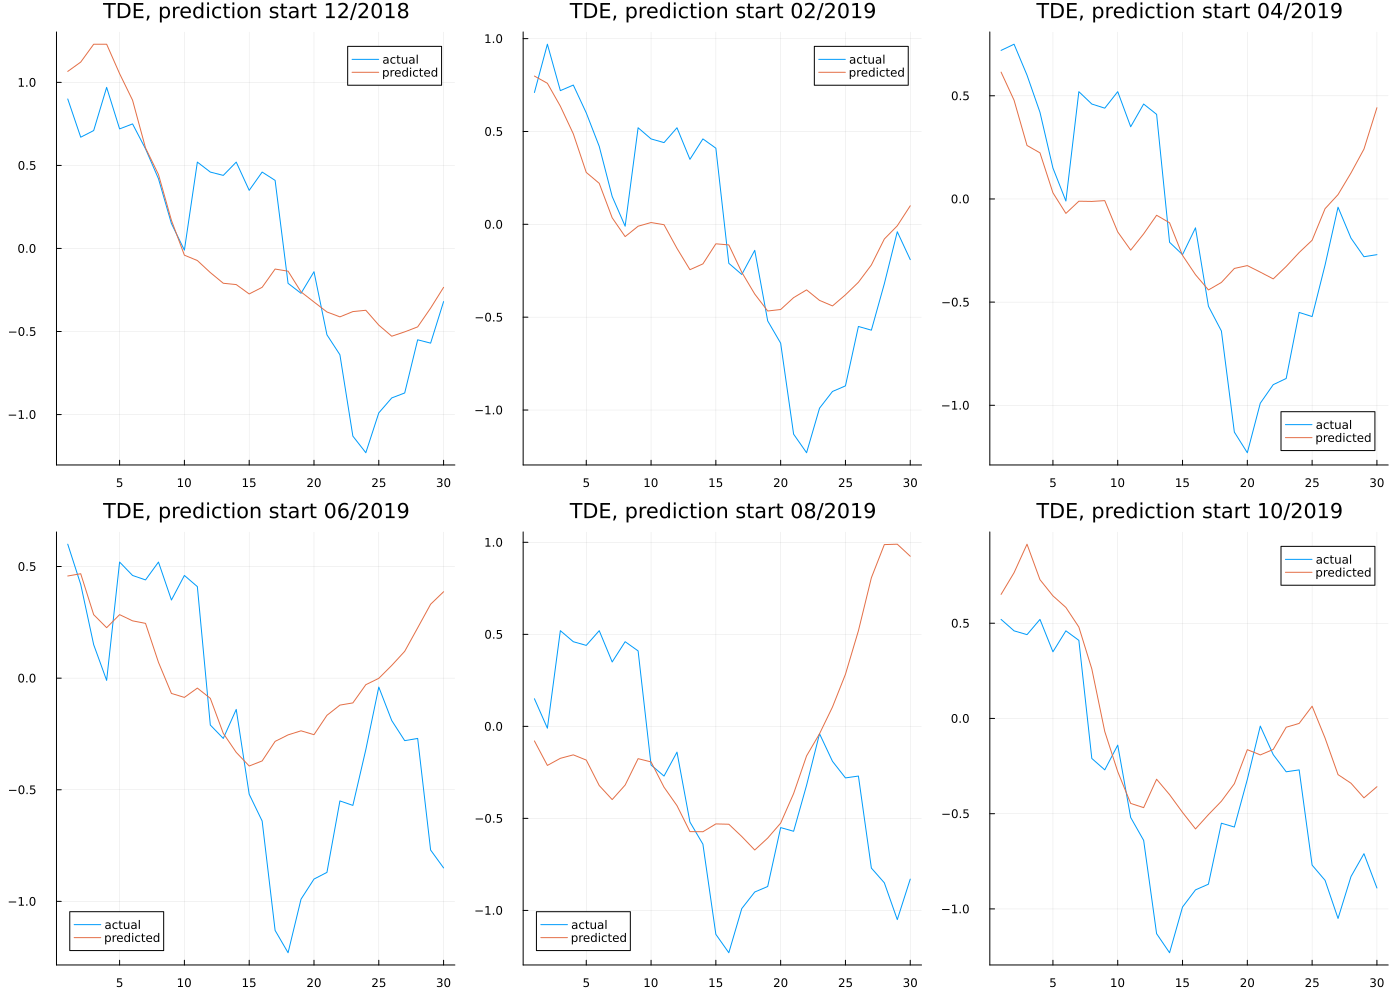

In [58]:
months = ["12/2018","02/2019","04/2019","06/2019","08/2019","10/2019"]
add = [0,2,4,6,8,10]
subplots = []
label = ["actual" "predicted"]
times =  collect(1:lead_time)
for i in eachindex(predictions[:,1])
    m = months[i]
    a = add[i]
    push!(subplots, plot(times, [test_data'[1, a+1 :a+lead_time], predictions[i, :]], label=label,  title="TDE, prediction start $m"))
end
plot(subplots..., layout=(2,3), size=(1400,1000))